In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor

In [2]:
def error(y, ypred):
    y_new, ypred_new = [], []
    for i, item in enumerate(y):
        if item != 0:
            y_new.append(item)
            ypred_new.append(ypred[i])
    y = np.array(y_new)
    ypred = np.array(ypred_new)
    
    return np.sqrt(1./len(y) * sum(((y - ypred) / y) ** 2))

def process_data(data):
    # Merge store data
    data = data.merge(store, on = 'Store', copy = False)
    
    # Break down date column
    data['year'] = data.Date.apply(lambda x: x.year)
    data['month'] = data.Date.apply(lambda x: x.month)
#     data['dow'] = data.Date.apply(lambda x: x.dayofweek)
    data['woy'] = data.Date.apply(lambda x: x.weekofyear)
    data.drop(['Date'], axis = 1, inplace= True)

    # Calculate time competition open in months
    data['CompetitionOpen'] = 12 * (data.year - data.CompetitionOpenSinceYear) + \
    (data.month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis = 1, 
             inplace = True)
    
    # Promo open time
    data['PromoOpen'] = 12 * (data.year - data.Promo2SinceYear) + \
    (data.woy - data.Promo2SinceWeek) / float(4)
    data['PromoOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data.drop(['Promo2SinceYear', 'Promo2SinceWeek'], axis = 1, 
             inplace = True)
    
    # Get promo months
    data['p_1'] = data.PromoInterval.apply(lambda x: x[:3] if type(x) == str else 0)
    data['p_2'] = data.PromoInterval.apply(lambda x: x[4:7] if type(x) == str else 0)
    data['p_3'] = data.PromoInterval.apply(lambda x: x[8:11] if type(x) == str else 0)
    data['p_4'] = data.PromoInterval.apply(lambda x: x[12:15] if type(x) == str else 0)
   
    # Get dummies
    data = pd.get_dummies(data, columns = ['p_1', 'p_2', 'p_3', 'p_4', 
                                           'StateHoliday' , 
#                                            'dow', 
                                           'StoreType', 
                                           'Assortment'])
    data.drop(['Store',
               'PromoInterval', 
               'p_1_0', 'p_2_0', 'p_3_0', 'p_4_0', 
               'StateHoliday_0', 
               'year'], axis=1,inplace=True)

    # data = data.drop(['dow', 'StateHoliday', 'StoreType', 'Assortment'], axis = 1)
    # #     data.dropna(axis = 1, inplace = True)
    
    # Fill in missing values
    data = data.fillna(0)
    data = data.sort_index(axis=1)
    
    return data

In [3]:
data = pd.read_csv('train.csv', parse_dates = ['Date'],dtype={'StateHoliday': str})
data = data[data['Open'] != 0]
store = pd.read_csv('store.csv')  

data = process_data(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 34 columns):
Assortment_a           844392 non-null float64
Assortment_b           844392 non-null float64
Assortment_c           844392 non-null float64
CompetitionDistance    844392 non-null float64
CompetitionOpen        844392 non-null float64
Customers              844392 non-null int64
DayOfWeek              844392 non-null int64
Open                   844392 non-null int64
Promo                  844392 non-null int64
Promo2                 844392 non-null int64
PromoOpen              844392 non-null float64
Sales                  844392 non-null int64
SchoolHoliday          844392 non-null int64
StateHoliday_a         844392 non-null float64
StateHoliday_b         844392 non-null float64
StateHoliday_c         844392 non-null float64
StoreType_a            844392 non-null float64
StoreType_b            844392 non-null float64
StoreType_c            844392 non-null float64
StoreType_

In [4]:
from sklearn.cross_validation import train_test_split

X = data.drop(['Sales', 'Customers'], axis = 1)
y = data.Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4)

model = RandomForestRegressor(n_jobs = -1, n_estimators = 15)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [5]:
print (error(y_test, y_pred))

0.187675810838


In [6]:
X.columns[np.argsort(model.feature_importances_)[::-1][:10]]

Index(['CompetitionDistance', 'Promo', 'DayOfWeek', 'woy', 'PromoOpen',
       'CompetitionOpen', 'StoreType_b', 'month', 'Promo2', 'StoreType_c'],
      dtype='object')

In [55]:
test = pd.read_csv('test.csv', parse_dates = ['Date'])
test = process_data(test)

for col in data.columns:
    if col not in test.columns:
        test[col] = np.zeros(test.shape[0])
        
test = test.sort_index(axis=1).set_index('Id')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 1 to 41088
Data columns (total 34 columns):
Assortment_a           41088 non-null float64
Assortment_b           41088 non-null float64
Assortment_c           41088 non-null float64
CompetitionDistance    41088 non-null float64
CompetitionOpen        41088 non-null float64
Customers              41088 non-null float64
DayOfWeek              41088 non-null int64
Open                   41088 non-null float64
Promo                  41088 non-null int64
Promo2                 41088 non-null int64
PromoOpen              41088 non-null float64
Sales                  41088 non-null float64
SchoolHoliday          41088 non-null int64
StateHoliday_a         41088 non-null float64
StateHoliday_b         41088 non-null float64
StateHoliday_c         41088 non-null float64
StoreType_a            41088 non-null float64
StoreType_b            41088 non-null float64
StoreType_c            41088 non-null float64
StoreType_d            41

In [57]:
#test_X = test.drop(['Store','Sales', 'Customers'], axis=1).values
test_X = test.drop(['Sales', 'Customers'], axis=1).values

In [58]:
ytest = model.predict(test_X)

In [59]:
result = pd.DataFrame({'Id': test.index.values, 'Sales': ytest}).set_index('Id')
result = result.sort_index()
result.to_csv('predictions.csv')

In [60]:
test = pd.read_csv('test.csv', parse_dates = ['Date'])
test.merge(store, on = 'Store', copy = False).drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1).set_index('Id')

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
Id,,,,,,,,,,,,,
1,1,4,2015-09-17,1,1,0,0,c,a,1270,9,2008,0
857,1,3,2015-09-16,1,1,0,0,c,a,1270,9,2008,0
1713,1,2,2015-09-15,1,1,0,0,c,a,1270,9,2008,0
2569,1,1,2015-09-14,1,1,0,0,c,a,1270,9,2008,0
3425,1,7,2015-09-13,0,0,0,0,c,a,1270,9,2008,0
4281,1,6,2015-09-12,1,0,0,0,c,a,1270,9,2008,0
5137,1,5,2015-09-11,1,0,0,0,c,a,1270,9,2008,0
5993,1,4,2015-09-10,1,0,0,0,c,a,1270,9,2008,0
6849,1,3,2015-09-09,1,0,0,0,c,a,1270,9,2008,0


<Container object of 32 artists>

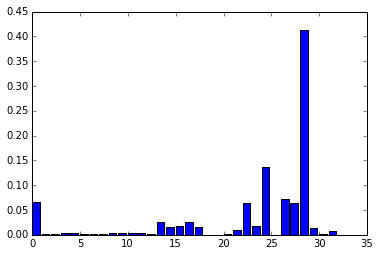

In [61]:
imps = model.feature_importances_[::-1]
x_imps = np.arange(len(imps))

plt.bar(x_imps, imps)

In [64]:
top_X = data.drop(['Sales','Customers'], axis=1).iloc[:, np.argsort(model.feature_importances_)[::-1][:10]]

top_X_train, top_X_test, y_train, y_test = train_test_split(top_X, y)

top_model = RandomForestRegressor(n_jobs = -1)
top_model.fit(top_X_train, y_train)
top_pred = top_model.predict(top_X_test)
print (error(top_pred, y_test))

KeyError: 0

In [448]:
top_test_X = test.drop(['Sales', 'Customers'], axis=1).iloc[:, np.argsort(model.feature_importances_)[::-1][:10]]

top_model.predict(top_test_X)

array([ 4849.9 ,  4942.3 ,  5475.2 , ...,  7779.91,     0.  ,  5388.06])

In [452]:
from sklearn.cross_validation import cross_val_score

cvs = cross_val_score(estimator=RandomForestRegressor(n_jobs = -1, n_estimators = 50), 
                      X = top_X,
                      y = y,
                      cv = 3,
                      n_jobs = -1,
                      verbose = 1)
print cvs

[Parallel(n_jobs=-1)]: Done   1 out of   3 | elapsed:  4.9min remaining:  9.8min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.0min finished


[ 0.38614541  0.3165081   0.36230987]


In [453]:
from sklearn.ensemble import GradientBoostingRegressor

gdb = GradientBoostingRegressor()
gdb.fit(top_X_train, y_train)

0.239191469141


In [454]:
gdb_pred = gdb.predict(top_X_test)
print error(gdb_pred, y_test)

0.52931310572


In [455]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada = AdaBoostRegressor(DecisionTreeRegressor())
ada.fit(top_X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

In [456]:
ada_pred = ada.predict(top_X_test)
print error(ada_pred, y_test)

0.246343607065


array([[  1.,   0.,   0., ...,   0.,   0.,  23.],
       [  1.,   0.,   0., ...,   0.,   1.,  23.],
       [  1.,   0.,   0., ...,   0.,   1.,  23.],
       ..., 
       [  0.,   0.,   1., ...,   0.,   0.,  23.],
       [  0.,   0.,   1., ...,   0.,   0.,  23.],
       [  0.,   0.,   1., ...,   0.,   0.,  23.]])